
<a id='von-neumann-model'></a>
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>


<a id='index-0'></a>

# Von Neumann Growth Model (and a Generalization)

## Contents

- [Von Neumann Growth Model (and a Generalization)](#Von-Neumann-Growth-Model-%28and-a-Generalization%29)  
  - [Notation](#Notation)  
  - [Model Ingredients and Assumptions](#Model-Ingredients-and-Assumptions)  
  - [Dynamic interpretation](#Dynamic-interpretation)  
  - [Duality](#Duality)  
  - [Interpretation as a Game Theoretic Problem (Two-player Zero-sum Game)](#Interpretation-as-a-Game-Theoretic-Problem-%28Two-player-Zero-sum-Game%29)  

**Co-author:** Balint Szoke

This notebook uses the class `Neumann` to calculate key objects of a
linear growth model of John von Neumann (1937) [[VN37]](https://lectures.quantecon.org/py/zreferences.html#von1937uber) that was generalized by
Kemeny, Moregenstern and Thompson (1956) [[KMT56]](https://lectures.quantecon.org/py/zreferences.html#kemeny1956generalization)

Objects of interest are the maximal expansion rate ($ \alpha $), the
interest factor ($ β $), and the optimal intensities ($ x $) and
prices ($ p $)

In addition to watching how the towering mind of John von Neumann
formulated an equilibrium model of price and quantity vectors in
balanced growth, this notebook shows how fruitfully to employ the
following important tools:

- a zero-sum two-player game  
- linear programming  
- the Perron-Frobenius theorem  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
from scipy.optimize import fsolve, linprog
from textwrap import dedent
%matplotlib inline

np.set_printoptions(precision=2)

The code below provides the `Neumann` class

In [2]:
class Neumann(object):
    """
    This class describes the Generalized von Neumann growth model as it was
    discussed in Kemeny et al. (1956, ECTA) :cite:`kemeny1956generalization` and Gale (1960, Chapter 9.5) :cite:`gale1989theory`:

    Let:
    n ... number of goods
    m ... number of activities
    A ... input matrix is m-by-n
        a_{i,j} - amount of good j consumed by activity i
    B ... output matrix is m-by-n
        b_{i,j} - amount of good j produced by activity i

    x ... intensity vector (m-vector) with nonnegative entries
        x'B - the vector of goods produced
        x'A - the vector of goods consumed
    p ... price vector (n-vector) with nonnegative entries
        Bp - the revenue vector for every activity
        Ap - the cost of each activity

    Both A and B have nonnegative entries. Moreover, we assume that
    (1) Assumption I (every good which is consumed is also produced):
        for all j, b_{.,j} > 0, i.e. at least one entry is strictly positive
    (2) Assumption II (no free lunch):
        for all i, a_{i,.} > 0, i.e. at least one entry is strictly positive

    Parameters
    ----------
    A : array_like or scalar(float)
        Part of the state transition equation.  It should be `n x n`
    B : array_like or scalar(float)
        Part of the state transition equation.  It should be `n x k`
    """

    def __init__(self, A, B):

        self.A, self.B = list(map(self.convert, (A, B)))
        self.m, self.n = self.A.shape

        # Check if (A, B) satisfy the basic assumptions
        assert self.A.shape == self.B.shape, 'The input and output matrices must have the same dimensions!'
        assert (self.A >= 0).all() and (self.B >= 0).all(), 'The input and output matrices must have only nonnegative entries!'

        # (1) Check whether Assumption I is satisfied:
        if (np.sum(B, 0) <= 0).any():
            self.AI = False
        else:
            self.AI = True

        # (2) Check whether Assumption II is satisfied:
        if (np.sum(A, 1) <= 0).any():
            self.AII = False
        else:
            self.AII = True

    def __repr__(self):
        return self.__str__()

    def __str__(self):

        me = """
        Generalized von Neumann expanding model:
          - number of goods          : {n}
          - number of activities     : {m}

        Assumptions:
          - AI:  every column of B has a positive entry    : {AI}
          - AII: every row of A has a positive entry       : {AII}

        """
        # Irreducible                                       : {irr}
        return dedent(me.format(n=self.n, m=self.m,
                                AI=self.AI, AII=self.AII))

    def convert(self, x):
        """
        Convert array_like objects (lists of lists, floats, etc.) into
        well formed 2D NumPy arrays
        """
        return np.atleast_2d(np.asarray(x))


    def bounds(self):
        """
        Calculate the trivial upper and lower bounds for alpha (expansion rate) and
        beta (interest factor). See the proof of Theorem 9.8 in Gale (1960) :cite:`gale1989theory`
        """

        n, m = self.n, self.m
        A, B = self.A, self.B

        f = lambda α: ((B - α * A) @ np.ones((n, 1))).max()
        g = lambda β: (np.ones((1, m)) @ (B - β * A)).min()

        UB = np.asscalar(fsolve(f, 1))  # Upper bound for α, β
        LB = np.asscalar(fsolve(g, 2))  # Lower bound for α, β

        return LB, UB


    def zerosum(self, γ, dual=False):
        """
        Given gamma, calculate the value and optimal strategies of a two-player
        zero-sum game given by the matrix

                M(gamma) = B - gamma * A

        Row player maximizing, column player minimizing

        Zero-sum game as an LP (primal --> α)

            max (0', 1) @ (x', v)
            subject to
            [-M', ones(n, 1)] @ (x', v)' <= 0
            (x', v) @ (ones(m, 1), 0) = 1
            (x', v) >= (0', -inf)

        Zero-sum game as an LP (dual --> beta)

            min (0', 1) @ (p', u)
            subject to
            [M, -ones(m, 1)] @ (p', u)' <= 0
            (p', u) @ (ones(n, 1), 0) = 1
            (p', u) >= (0', -inf)

        Outputs:
        --------
        value: scalar
            value of the zero-sum game

        strategy: vector
            if dual = False, it is the intensity vector,
            if dual = True, it is the price vector
        """

        A, B, n, m = self.A, self.B, self.n, self.m
        M = B - γ * A

        if dual == False:
            # Solve the primal LP (for details see the description)
            # (1) Define the problem for v as a maximization (linprog minimizes)
            c = np.hstack([np.zeros(m), -1])

            # (2) Add constraints :
            # ... non-negativity constaints
            bounds = tuple(m * [(0, None)] + [(None, None)])
            # ... inequality constaints
            A_iq = np.hstack([-M.T, np.ones((n, 1))])
            b_iq = np.zeros((n, 1))
            # ... normalization
            A_eq = np.hstack([np.ones(m), 0]).reshape(1, m + 1)
            b_eq = 1

            res = linprog(c, A_ub=A_iq, b_ub=b_iq, A_eq=A_eq, b_eq=b_eq,
                          bounds=bounds, options=dict(bland=True, tol=1e-7))

        else:
            # Solve the dual LP (for details see the description)
            # (1) Define the problem for v as a maximization (linprog minimizes)
            c = np.hstack([np.zeros(n), 1])

            # (2) Add constraints :
            # ... non-negativity constaints
            bounds = tuple(n * [(0, None)] + [(None, None)])
            # ... inequality constaints
            A_iq = np.hstack([M, -np.ones((m, 1))])
            b_iq = np.zeros((m, 1))
            # ... normalization
            A_eq = np.hstack([np.ones(n), 0]).reshape(1, n + 1)
            b_eq = 1

            res = linprog(c, A_ub=A_iq, b_ub=b_iq, A_eq=A_eq, b_eq=b_eq,
                          bounds=bounds, options=dict(bland=True, tol=1e-7))

        if res.status != 0:
            print(res.message)

        # Pull out the required quantities
        value = res.x[-1]
        strategy = res.x[:-1]

        return value, strategy


    def expansion(self, tol=1e-8, maxit=1000):
        """
        The algorithm used here is described in Hamburger-Thompson-Weil (1967, ECTA).
        It is based on a simple bisection argument and utilizes the idea that for
        a given γ (= α or β), the matrix "M = B - γ * A" defines a
        two-player zero-sum game, where the optimal strategies are the (normalized)
        intensity and price vector.

        Outputs:
        --------
        alpha: scalar
            optimal expansion rate
        """

        LB, UB = self.bounds()

        for iter in range(maxit):

            γ = (LB + UB) / 2
            ZS = self.zerosum(γ=γ)
            V = ZS[0]     # value of the game with γ

            if V >= 0:
                LB = γ
            else:
                UB = γ

            if abs(UB - LB) < tol:
                γ = (UB + LB) / 2
                x = self.zerosum(γ=γ)[1]
                p = self.zerosum(γ=γ, dual=True)[1]
                break

        return γ, x, p

    def interest(self, tol=1e-8, maxit=1000):
        """
        The algorithm used here is described in Hamburger-Thompson-Weil (1967, ECTA).
        It is based on a simple bisection argument and utilizes the idea that for
        a given gamma (= alpha or beta), the matrix "M = B - γ * A" defines a
        two-player zero-sum game, where the optimal strategies are the (normalized)
        intensity and price vector.

        Outputs:
        --------
        beta: scalar
            optimal interest rate
        """

        LB, UB = self.bounds()

        for iter in range(maxit):
            γ = (LB + UB) / 2
            ZS = self.zerosum(γ=γ, dual=True)
            V = ZS[0]

            if V > 0:
                LB = γ
            else:
                UB = γ

            if abs(UB - LB) < tol:
                γ = (UB + LB) / 2
                p = self.zerosum(γ=γ, dual=True)[1]
                x = self.zerosum(γ=γ)[1]
                break

        return γ, x, p

## Notation

We use the following notation

$ \mathbf{0} $ denotes
a vector of zeros. We call an $ n $-vector - positive or
$ x\gg \mathbf{0} $ if $ x_i>0 $ for all $ i=1,2,\dots,n $
- nonnegative or $ x\geq \mathbf{0} $ if $ x_i\geq 0 $ for
all $ i=1,2,\dots,n $ - semipositive or $ x > \mathbf{0} $ if
$ x\geq \mathbf{0} $ and $ x\neq \mathbf{0} $

For two comformable vectors $ x $ and $ y $, $ x\gg y $,
$ x\geq y $ and $ x> y $ mean $ x-y\gg \mathbf{0} $,
$ x-y \geq \mathbf{0} $, and $ x-y > \mathbf{0} $

By default, all vectors are column vectors, $ x^{T} $ denotes the
transpose of $ x $ (i.e. a row vector)

Let $ \iota_n $ denote a
column vector composed of $ n $ ones, i.e.
$ \iota_n = (1,1,\dots,1)^T $

Let $ e^i $ denote the vector (of
arbitrary size) containing zeros except for the $ i $ th position
where it is one

We denote matrices by capital letters. For an arbitrary matrix
$ A $, $ a_{i,j} $ represents the entry in its $ i $ th
row and $ j $ th column

$ a_{\cdot j} $ and $ a_{i\cdot} $
denote the $ j $ th column and $ i $ th row of $ A $,
respectively

## Model Ingredients and Assumptions

A pair $ (A,B) $ of $ m\times n $ nonnegative matrices defines
an economy.

- $ m $ is the number of *activities* (or sectors)  
- $ n $ is the number of *goods* (produced and/or used in the
  economy)  
- $ A $ is called the *input matrix*; $ a_{i,j} $ denotes the
  amount of good $ j $ consumed by activity $ i $  
- $ B $ is called the *output matrix*; $ b_{i,j} $ represents
  the amount of good $ j $ produced by activity $ i $  


Two key assumptions restrict economy $ (A,B) $:

- **Assumption I:** (every good which is consumed is also produced)  


$$
b_{.,j} > \mathbf{0}\hspace{5mm}\forall j=1,2,\dots,n
$$

- **Assumption II:** (no free lunch)  


$$
a_{i,.} > \mathbf{0}\hspace{5mm}\forall i=1,2,\dots,m
$$

A semipositive $ m $-vector:math:x denotes the levels at which
activities are operated (*intensity vector*)

Therefore,

- vector $ x^TA $ gives the total amount of *goods used in
  production*  
- vector $ x^TB $ gives *total outputs*  


An economy $ (A,B) $ is said to be *productive*, if there exists a
nonnegative intensity vector $ x \geq 0 $ such
that $ x^T B > x^TA $

The semipositive $ n $-vector $ p $ contains prices assigned to
the $ n $ goods

The $ p $ vector implies *cost* and *revenue* vectors

- the vector $ Ap $ tells *costs* of the vector of activities  
- the vector $ Bp $ tells *revenues* from the vector of activities  


A property of an input-output pair $ (A,B) $ called *irreducibility*
(or indecomposability) determines whether an economy can be decomposed
into multiple ‘’sub-economies’’

**Definition:** Given an economy $ (A,B) $, the set of goods
$ S\subset \{1,2,\dots,n\} $ is called an *independent subset* if
it is possible to produce every good in $ S $ without consuming any
good outside $ S $. Formally, the set $ S $ is independent if
$ \exists T\subset \{1,2,\dots,m\} $ (subset of activities) such
that $ a_{i,j}=0 $, $ \forall i\in T $ and $ j\in S^c $ and
for all $ j\in S $, $ \exists i\in T $, s.t. $ b_{i,j}>0 $.
The economy is **irreducible** if there are no proper independent
subsets

We study two examples, both coming from Chapter 9.6 of Gale (1960) [[Gal89]](https://lectures.quantecon.org/py/zreferences.html#gale1989theory)

In [3]:
# (1) Irreducible (A, B) example: α_0 = β_0
A1 = np.array([[0, 1, 0, 0],
               [1, 0, 0, 1],
               [0, 0, 1, 0]])

B1 = np.array([[1, 0, 0, 0],
               [0, 0, 2, 0],
               [0, 1, 0, 1]])

# (2) Reducible (A, B) example: β_0 < α_0
A2 = np.array([[0, 1, 0, 0, 0, 0],
               [1, 0, 1, 0, 0, 0],
               [0, 0, 0, 1, 0, 0],
               [0, 0, 1, 0, 0, 1],
               [0, 0, 0, 0, 1, 0]])

B2 = np.array([[1, 0, 0, 1, 0, 0],
               [0, 1, 0, 0, 0, 0],
               [0, 0, 1, 0, 0, 0],
               [0, 0, 0, 0, 2, 0],
               [0, 0, 0, 1, 0, 1]])

The following code sets up our first Neumann economy or `Neumann`
instance

In [4]:
N1 = Neumann(A1, B1)
N1


Generalized von Neumann expanding model:
  - number of goods          : 4
  - number of activities     : 3

Assumptions:
  - AI:  every column of B has a positive entry    : True
  - AII: every row of A has a positive entry       : True


In [5]:
N2 = Neumann(A2, B2)
N2


Generalized von Neumann expanding model:
  - number of goods          : 6
  - number of activities     : 5

Assumptions:
  - AI:  every column of B has a positive entry    : True
  - AII: every row of A has a positive entry       : True


## Dynamic interpretation

Attach a time index $ t $ to the preceding objects, regard an economy
as a dynamic system, and study sequences

$$
\{(A_t,B_t)\}_{t\geq 0}, \hspace{1cm}\{x_t\}_{t\geq 0},\hspace{1cm} \{p_t\}_{t\geq 0}
$$

An interesting special case holds the technology process constant and
investigates the dynamics of quantities and prices only

Accordingly, in the rest of this notebook we assume that
$ (A_t,B_t)=(A,B) $ for all $ t\geq 0 $

A crucial element of the dynamic iterpretation involves the timing of
production

We assume that production (consumption of inputs) takes place in period
$ t $, while the associated output materializes in period
$ t+1 $, i.e. consumption of $ x_{t}^TA $ in period $ t $
results in $ x^T_{t}B $ amounts of output in period $ t+1 $

These timing conventions imply the following feasibiliy condition:

$$
\begin{align}
x^T_{t}B \geq x^T_{t+1} A \hspace{1cm}\forall t\geq 1
\end{align}
$$

which asserts that no more goods can be used today than were produced
yesterday

Accordingly, $ Ap_t $ tells the costs of production in period
$ t $ and $ Bp_t $ tells revenues in period $ t+1 $

### Balanced growth

We follow John von Neumann in studying “balanced growth”

Let $ ./ $ denote elementwise division of one vector by another and let
$ \alpha >0 $ be a scalar

Then *balanced growth* is a situation in which

$$
x_{t+1}./x_t = \alpha , \quad \forall t \geq 0
$$

With balanced growth, the law of motion of $ x $ is evidently $ x_{t+1}=\alpha x_t $
and so we can rewrite the feasibility constraint as

$$
x^T_{t}B \geq \alpha x^T_t A \hspace{1cm}\forall t
$$

In the same spirit, define $ \beta\in\mathbb{R} $ as the **interest
factor** per unit of time

We assume that it is always possible to earn a gross return equal to the
constant interest factor $ \beta $ by investing “outside the model”

Under this assumption about outside investment opportunities, a
no-arbitrage condition gives rise to the following (no profit)
restriction on the price sequence:

$$
\beta Ap_{t} \geq B p_{t} \hspace{1cm}\forall t
$$

This says that production cannot yield a return greater than that
offered by the investment opportunity (note that we compare values in
period $ t+1 $)

The balanced growth assumption allows us to drop time subscripts and
conduct an analysis purely in terms of a time-invariant growth rate
$ \alpha $ and interest factor $ \beta $

## Duality

The following two problems are connected by a remarkable dual
relationship between the technological and valuation characteristics of
the economy:

**Definition:** The *technological expansion problem* (TEP) for economy
$ (A,B) $ is to find a semipositive $ m $-vector $ x>0 $
and a number $ \alpha\in\mathbb{R} $, s.t.

$$
\begin{align*}
  &\max_{\alpha} \hspace{2mm} \alpha\\
  &\text{s.t. }\hspace{2mm}x^T B \geq \alpha x^T A
  \end{align*}
$$

Theorem 9.3 of David Gale’s book [[Gal89]](https://lectures.quantecon.org/py/zreferences.html#gale1989theory) assets that if Assumptions I and II are
both satisfied, then a maximum value of $ \alpha $ exists and it is
positive

It is called the *technological expansion rate* and is denoted
by $ \alpha_0 $. The associated intensity vector $ x_0 $ is the
*optimal intensity vector*

**Definition:** The *economical expansion problem* (EEP) for
$ (A,B) $ is to find a semipositive $ n $-vector $ p>0 $
and a number $ \beta\in\mathbb{R} $, such that

$$
\begin{align*}
  &\min_{\beta} \hspace{2mm} \beta\\
  &\text{s.t. }\hspace{2mm}Bp \leq \beta Ap
  \end{align*}
$$

Assumptions I and II imply existence of a minimum value
$ \beta_0>0 $ called the *economic expansion rate*

The corresponding price vector $ p_0 $ is the *optimal price vector*

Evidently, the criterion functions in *technological expansion* problem
and the *economical expansion problem* are both linearly homogeneous, so
the optimality of $ x_0 $ and $ p_0 $ are defined only up to a
positive scale factor

For simplicity (and to emphasize a close connection to zero-sum games),
in the following, we normalize both vectors
$ x_0 $ and $ p_0 $ to have unit length

A standard duality argument (see Lemma 9.4. in (Gale, 1960) [[Gal89]](https://lectures.quantecon.org/py/zreferences.html#gale1989theory)) implies
that under Assumptions I and II, $ \beta_0\leq \alpha_0 $

But in the other direction, that is $ \beta_0\geq \alpha_0 $,
Assumptions I and II are not sufficient

Nevertheless, von Neumann (1937) [[VN37]](https://lectures.quantecon.org/py/zreferences.html#von1937uber) proved the following remarkable
“duality-type” result connecting TEP and EEP

**Theorem 1 (von Neumann):** If the economy $ (A,B) $ satisfies
Assumptions I and II, then there exists a set
$ \left(\gamma^{*}, x_0, p_0\right) $, where
$ \gamma^{*}\in[\beta_0, \alpha_0]\subset\mathbb{R} $, $ x_0>0 $
is an $ m $-vector, $ p_0>0 $ is an $ n $-vector and the
following holds true

$$
\begin{align*}
x_0^T B &\geq \gamma^{* } x_0^T A \\
Bp_0 &\leq \gamma^{* } Ap_0 \\
x_0^T\left(B-\gamma^{* } A\right)p_0 &= 0
\end{align*}
$$

> *Proof (Sketch):* Assumption I and II imply that there exist $ (\alpha_0,
x_0) $ and $ (\beta_0, p_0) $ solving the TEP and EEP, repspectively. If
$ \gamma^*>\alpha_0 $, then by defintion of $ \alpha_0 $, there cannot
exist a semipositive $ x $ that satisfies $ x^T B \geq \gamma^{* }
x^T A $.  Similarly, if $ \gamma^*<\beta_0 $, there is no semipositive
$ p $ so that $ Bp \leq \gamma^{* } Ap $. Let $ \gamma^{*
}\in[\beta_0, \alpha_0] $, then $ x_0^T B \geq \alpha_0 x_0^T A \geq
\gamma^{* } x_0^T A $.  Moreover, $ Bp_0\leq \beta_0 A p_0\leq \gamma^* A
p_0 $. This two inequalities imply $ x_0\left(B - \gamma^{* } A\right)p_0
= 0 $.


Here the constant $ \gamma^{*} $ is both expansion and interest
factor (not neccessarily optimal)

We have already encountered and
discussed the first two inequalities that represent feasibility and
no-profit conditions

Moreover, the equality compactly captures the
requirements that if any good grows at a rate larger than
$ \gamma^{*} $ (i.e., if it is *oversupplied*), then its price
must be zero; and that if any activity provides negative profit, it must
be unused

Therefore, these expressions encode all equilbrium conditions
and Theorem I essentially states that under Assumptions I and II there
always exists an equilibrium $ \left(\gamma^{*}, x_0, p_0\right) $
with balanced growth

Note that Theorem I is silent about uniqueness of the equilibrium. In
fact, it does not rule out (trivial) cases with $ x_0^TBp_0 = 0 $ so
that nothing of value is produce

To exclude such uninteresting cases,
Kemeny, Morgenstern and Thomspson (1956) add an extra requirement

$$
x^T_0 B p_0 > 0
$$

and call the resulting equilibria *economic solutions*

They show that
this extra condition does not affect the existence result, while it
significantly reduces the number of (relevant) solutions

## Interpretation as a Game Theoretic Problem (Two-player Zero-sum Game)

To compute the equilibrium $ (\gamma^{*}, x_0, p_0) $, we follow the
algorithm proposed by Hamburger, Thompson and Weil (1967), building on
the key insight that the equilibrium (with balanced growth) can be
considered as a solution of a particular two-player zero-sum game.
First, we introduce some notations

Consider the $ m\times n $ matrix $ C $ as a payoff matrix,
with the entries representing payoffs from the **minimizing** column
player to the **maximizing** row player and assume that the players can
use mixed strategies: - row player chooses the $ m $-vector
$ x > \mathbf{0} $, s.t. $ \iota_m^T x = 1 $ - column player
chooses the $ n $-vector $ p > \mathbf{0} $,
s.t. $ \iota_n^T p = 1 $

**Definition:** The $ m\times n $ matrix game $ C $ has the
*solution* $ (x^*, p^*, V(C)) $ in mixed strategies, if

$$
\begin{align}
(x^* )^T C e^j \geq V(C)\quad \forall j\in\{1, \dots, n\}\quad \quad
\text{and}\quad\quad (e^i)^T C p^* \leq V(C)\quad \forall i\in\{1, \dots, m\}
\end{align}
$$

The number $ V(C) $ is called the *value* of the game

From the above definition, it is clear that the value $ V(C) $ has
two alternative interpretations:

- by playing the appropriate mixed
  stategy, the maximizing player can assure himself at least $ V(C) $
  (no matter what the column player chooses)  
- by playing the appropriate
  mixed stategy, the minimizing player can make sure that the maximizing
  player will not get more than $ V(C) $ (irrespective of what is the
  maximizing player’s choice)  


From the famous theorem of Nash (1951), it follows that there always
exists a mixed strategy Nash equilibrium for any *finite* two-player
zero-sum game

Moreover, von Neumann’s Minmax Theorem (1928) [[Neu28]](https://lectures.quantecon.org/py/zreferences.html#neumann1928theorie) implies that

$$
V(C) = \max_x \min_p \hspace{2mm} x^T C p = \min_p \max_x \hspace{2mm} x^T C p = (x^*)^T C p^*
$$

### Connection with Linear Programming (LP)

Finding Nash equilibria of a finite two-player zero-sum game can be
formulated as a linear programming problem

To see this, we introduce
the following notation - For a fixed $ x $, let $ v $ be the
value of the minimization problem:
$ v \equiv \min_p x^T C p = \min_j x^T C e^j $ - For a fixed
$ p $, let $ u $ be the value of the maximization problem:
$ u \equiv \max_x x^T C p = \max_i (e^i)^T C p $

Then the *max-min problem* (the game from the maximizing player’s point
of view) can be written as the *primal* LP

$$
\begin{align}
V(C) = & \max \hspace{2mm} v \\
\text{s.t. } \hspace{2mm} v \iota_n^T &\leq x^T C  \\
x &\geq \mathbf{0} \\
\iota_n^T x & = 1
\end{align}
$$

while the *min-max problem* (the game from the minimizing player’s point
of view) is the *dual* LP

$$
\begin{align}
V(C) = &\min \hspace{2mm} u \\
\text{s.t. } \hspace{2mm}u \iota_m &\geq Cp  \\
p &\geq \mathbf{0} \\
\iota_m^T p & = 1
\end{align}
$$

Hamburger, Thompson and Weil (1967) [[HTW67]](https://lectures.quantecon.org/py/zreferences.html#hamburger1967computation) view the input-output pair of the
economy as payoff matrices of two-player zero-sum games. Using this
interpretation, they restate Assumption I and II as follows

$$
V(-A) < 0\quad\quad \text{and}\quad\quad V(B)>0
$$

> *Proof (Sketch)*: * $ \Rightarrow $ $ V(B)>0 $ implies
$ x_0^T B \gg \mathbf{0} $, where $ x_0 $ is a maximizing
vector. Since $ B $ is non-negative, this requires that each
column of $ B $ has at least one positive entry, which is
Assumption I. * $ \Leftarrow $ From Assumption I and the fact
that $ p>\mathbf{0} $, it follows that $ Bp > \mathbf{0} $.
This implies that the maximizing player can always choose $ x $
so that $ x^TBp>0 $, that is it must be the case
that $ V(B)>0 $


In order to (re)state Theorem I in terms of a particular two-player
zero-sum game, we define the matrix for $ \gamma\in\mathbb{R} $

$$
M(\gamma) \equiv B - \gamma A
$$

For fixed $ \gamma $, treating $ M(\gamma) $ as a matrix game,
we can calculate the solution of the game

- If $ \gamma > \alpha_0 $, then for all $ x>0 $, there
  $ \exists j\in\{1, \dots, n\} $, s.t.
  $ [x^T M(\gamma)]_j < 0 $ implying
  that $ V(M(\gamma)) < 0 $  
- If $ \gamma < \beta_0 $, then for all $ p>0 $, there
  $ \exists i\in\{1, \dots, m\} $, s.t.
  $ [M(\gamma)p]_i > 0 $ implying that $ V(M(\gamma)) > 0 $  
- If $ \gamma \in \{\beta_0, \alpha_0\} $, then (by Theorem I) the
  optimal intensity and price vectors $ x_0 $ and $ p_0 $
  satisfy  


$$
\begin{align}
x_0^T M(\gamma) \geq \mathbf{0}^T \quad \quad \text{and}\quad\quad M(\gamma) p_0 \leq \mathbf{0}
\end{align}
$$

That is, $ (x_0, p_0, 0) $ is a solution of the game
$ M(\gamma) $ so
that $ V\left(M(\beta_0)\right) = V\left(M(\alpha_0)\right) = 0 $

* If $ \beta_0 < \alpha_0 $ and
$ \gamma \in (\beta_0, \alpha_0) $, then $ V(M(\gamma)) = 0 $

Moreover, if $ x' $ is optimal for the maximizing player in
$ M(\gamma') $ for $ \gamma'\in(\beta_0, \alpha_0) $ and
$ p'' $ is optimal for the minimizing player in $ M(\gamma'') $
where $ \gamma''\in(\beta_0, \gamma') $, then $ (x', p'', 0) $
is a solution for
$ M(\gamma) $, $ \forall \gamma\in (\gamma'', \gamma') $

> *Proof (Sketch):* If $ x' $ is optimal for a maximizing player in
game $ M(\gamma') $, then $ (x')^T M(\gamma')\geq \mathbf{0}^T $
and so for all $ \gamma<\gamma' $


$$
(x')^T M(\gamma) = (x')^T M(\gamma') + (x')^T(\gamma' - \gamma)A \geq \mathbf{0}^T
$$

hence $ V(M(\gamma))\geq 0 $. If $ p'' $ is optimal for a
minimizing player in game $ M(\gamma'') $, then $ M(\gamma)p \leq \mathbf{0} $
and so for all $ \gamma''<\gamma $

$$
M(\gamma)p'' = M(\gamma'') + (\gamma'' - \gamma)Ap'' \leq \mathbf{0}
$$

hence $ V(M(\gamma))\leq 0 $

It is clear from the above argument that $ \beta_0 $,
$ \alpha_0 $ are the minimal and maximal $ \gamma $ for which
$ V(M(\gamma))=0 $

Moreover, Hamburger et al. (1967) [[HTW67]](https://lectures.quantecon.org/py/zreferences.html#hamburger1967computation) show that the
function $ \gamma \mapsto V(M(\gamma)) $ is continuous and
nonincreasing in $ \gamma $

This suggests an algorithm to compute
$ (\alpha_0, x_0) $ and $ (\beta_0, p_0) $ for a given
input-output pair $ (A, B) $

### Algorithm

Hamburger, Thompson and Weil (1967) [[HTW67]](https://lectures.quantecon.org/py/zreferences.html#hamburger1967computation) propose a simple bisection algorithm
to find the minimal and maximal roots (i.e. $ \beta_0 $ and
$ \alpha_0 $) of the function $ \gamma \mapsto V(M(\gamma)) $

#### Step 1

First, notice that we can easily find trivial upper and lower bounds for
$ \alpha_0 $ and $ \beta_0 $

* TEP requires that
$ x^T(B-\alpha A)\geq \mathbf{0}^T $ and $ x > \mathbf{0} $, so
if $ \alpha $ is so large that
$ \max_i\{[(B-\alpha A)\iota_n]_i\} < 0 $, then TEP ceases to have a
solution

Accordingly, let **``UB``** be the $ \alpha^{*} $ that
solves $ \max_i\{[(B-\alpha^{*} A)\iota_n]_i\} = 0 $

* Similar to
the upper bound, if $ \beta $ is so low that
$ \min_j\{[\iota^T_m(B-\beta A)]_j\}>0 $, then the EEP has no
solution and so we can define **``LB``** as the $ \beta^{*} $ that
solves $ \min_j\{[\iota^T_m(B-\beta^{*} A)]_j\}=0 $

The *bounds* method calculates these trivial bounds for us

In [6]:
N1.bounds()

(1.0, 2.0)

#### Step 2

Compute $ \alpha_0 $ and $ \beta_0 $

- Finding $ \alpha_0 $  
  1. Fix $ \gamma = \frac{UB + LB}{2} $ and compute the solution
    of the two-player zero-sum game associated
    with $ M(\gamma) $. We can use either the primal or the dual
    LP problem  
  1. If $ V(M(\gamma)) \geq 0 $, then set $ LB = \gamma $,
    otherwise let $ UB = \gamma $  
  1. Iterate on 1. and 2. until $ |UB - LB| < \epsilon $  
- Finding $ \beta_0 $  
  1. Fix $ \gamma = \frac{UB + LB}{2} $ and compute the solution
    of the two-player zero-sum game associated
    with $ M(\gamma) $. We can use either the primal or the dual
    LP problem  
  1. If $ V(M(\gamma)) > 0 $, then set $ LB = \gamma $,
    otherwise let $ UB = \gamma $  
  1. Iterate on 1. and 2. until $ |UB - LB| < \epsilon $  
  *Existence*: Since $ V(M(LB))>0 $ and $ V(M(UB))<0 $ and
  $ V(M(\cdot)) $ is a continuous, nonincreasing function, there is
  at least one $ \gamma\in[LB, UB] $, s.t. $ V(M(\gamma))=0 $  


The *zerosum* method calculates the value and optimal strategies
assocaited with a given $ \gamma $

In [7]:
γ = 2

print(f'Value of the game with γ = {γ}')
print(N1.zerosum(γ=γ)[0])
print('Intensity vector (from the primal)')
print(N1.zerosum(γ=γ)[1])
print('Price vector (from the dual)')
print(N1.zerosum(γ=γ, dual=True)[1])

Value of the game with γ = 2
-0.24
Intensity vector (from the primal)
[0.32 0.28 0.4 ]
Price vector (from the dual)
[0.4  0.32 0.28 0.  ]


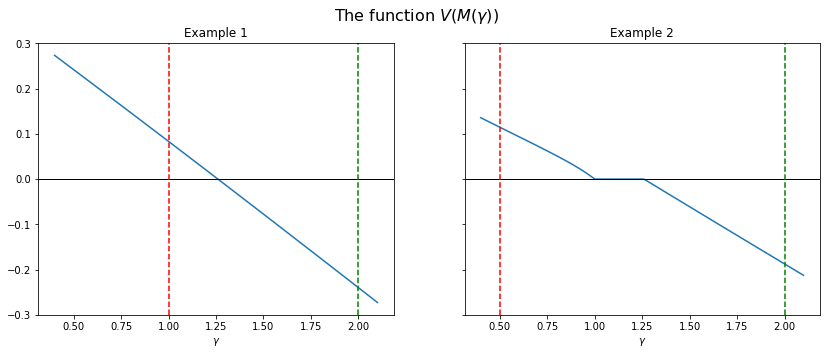

In [8]:
numb_grid = 100
γ_grid = np.linspace(0.4, 2.1, numb_grid)

value_ex1_grid = np.asarray([N1.zerosum(γ=γ_grid[i])[0] for i in range(numb_grid)])
value_ex2_grid = np.asarray([N2.zerosum(γ=γ_grid[i])[0] for i in range(numb_grid)])

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
fig.suptitle(r'The function $V(M(\gamma))$', fontsize=16)

for ax, grid, N, i in zip(axes, (value_ex1_grid, value_ex2_grid), (N1, N2), (1, 2)):
    ax.plot(γ_grid, grid)
    ax.set(title=f'Example {i}', xlabel='$\gamma$')
    ax.axhline(0, c='k', lw=1)
    ax.axvline(N.bounds()[0], c='r', ls='--', label='lower bound')
    ax.axvline(N.bounds()[1], c='g', ls='--', label='upper bound')

plt.show()

The *expansion* method implements the bisection algorithm for
$ \alpha_0 $ (and uses the primal LP problem for $ x_0 $)

In [9]:
α_0, x, p = N1.expansion()
print(f'α_0 = {α_0}')
print(f'x_0 = {x}')
print(f'The corresponding p from the dual = {p}')

α_0 = 1.2599210478365421
x_0 = [0.33 0.26 0.41]
The corresponding p from the dual = [0.41 0.33 0.26 0.  ]


The *interest* method implements the bisection algorithm for
$ \beta_0 $ (and uses the dual LP problem for $ p_0 $)

In [10]:
β_0, x, p = N1.interest()
print(f'β_0 = {β_0}')
print(f'p_0 = {p}')
print(f'The corresponding x from the primal = {x}')

β_0 = 1.2599210478365421
p_0 = [0.41 0.33 0.26 0.  ]
The corresponding x from the primal = [0.33 0.26 0.41]


Of course, when $ \gamma^* $ is unique, it is irrelevant which one
of the two methods we use

In particular, as will be shown below, in
case of an irreducible $ (A,B) $ (like in Example 1), the maximal
and minimal roots of $ V(M(\gamma)) $ necessarily coincide implying
a ‘’full duality’’ result, i.e. $ \alpha_0 = \beta_0 = \gamma^* $,
and that the expansion (and interest) rate $ \gamma^* $ is unique

### Uniqueness and irreducibility

As an illustration, compute first the maximal and minimal roots of
$ V(M(\cdot)) $ for Example 2, which displays a reducible
input-output pair $ (A, B) $

In [11]:
α_0, x, p = N2.expansion()
print(f'α_0 = {α_0}')
print(f'x_0 = {x}')
print(f'The corresponding p from the dual = {p}')

α_0 = 1.2528658034279943
x_0 = [0.   0.   0.33 0.26 0.41]
The corresponding p from the dual = [0.56 0.44 0.   0.   0.   0.  ]


In [12]:
β_0, x, p = N2.interest()
print(f'β_0 = {β_0}')
print(f'p_0 = {p}')
print(f'The corresponding x from the primal = {x}')

β_0 = 1.0000000009313226
p_0 = [0.5 0.5 0.  0.  0.  0. ]
The corresponding x from the primal = [0.33 0.33 0.33 0.   0.  ]


As we can see, with a reducible $ (A,B) $, the roots found by the
bisection alhorithms might differ, so there might be multiple
$ \gamma^* $ that make the value of the game
with $ M(\gamma^*) $ zero. (see the figure above)

Indeed, although the von Neumann theorem assures existence of the
equilibrium, Assumptions I and II are not sufficient for uniqueness.
Nonetheless, Kemeny et al. (1967) show that there are at most finitely
many economic solutions, meaning that there are only finitely many
$ \gamma^* $ that satisfy $ V(M(\gamma^*)) = 0 $ and
$ x_0^TBp_0 > 0 $ and that for each such $ \gamma^*_i $, there
is a self-sufficient part of the economy (a sub-economy) that in
equilibrium can expand independently with the expansion
coefficient $ \gamma^*_i $

The following theorem (see Theorem 9.10. in Gale, 1960 [[Gal89]](https://lectures.quantecon.org/py/zreferences.html#gale1989theory)) asserts that
imposing irreducibility is sufficient for uniqueness of
$ (\gamma^*, x_0, p_0) $

**Theorem II:** Consider the conditions of Theorem 1. If the economy
$ (A,B) $ is irreducible, then $ \gamma^*=\alpha_0=\beta_0 $

### A special case

There is a special $ (A,B) $ that allows us to simplify the solution
method significantly by invoking the powerful Perron-Frobenius theorem
for nonnegative matrices

**Definition:** We call an economy *simple* if it satisfies 1.
$ n=m $ 2. Each activity produces exactly one good 3. Each good is
produced by one and only one activity

These assumptions imply that $ B=I_n $, i.e., that $ B $ can be
written as an identity matrix (possibly after reshuffling its rows and
columns)

The simple model has the following special property (Theorem 9.11. in [[Gal89]](https://lectures.quantecon.org/py/zreferences.html#gale1989theory)): if $ x_0 $ and $ \alpha_0>0 $ solve the TEP
with $ (A,I_n) $, then

$$
x_0^T = \alpha_0 x_0^T A\hspace{1cm}\Leftrightarrow\hspace{1cm}x_0^T
A=\left(\frac{1}{\alpha_0}\right)x_0^T
$$

The latter shows that $ 1/\alpha_0 $ is a positive eigenvalue of
$ A $ and $ x_0 $ is the correponding nonnegative left
eigenvector

The classical result of **Perron and Frobenius** implies
that a nonnegative matrix always has a nonnegative
eigenvalue-eigenvector pair

Moreover, if $ A $ is irreducible, then
the optimal intensity vector $ x_0 $ is positive and *unique* up to
multiplication by a positive scalar

Suppose that $ A $ is reducible with $ k $ irreducible subsets
$ S_1,\dots,S_k $. Let $ A_i $ be the submatrix corresponding to
$ S_i $ and let $ \alpha_i $ and $ \beta_i $ be the
associated expansion and interest factors, respectively. Then we have

$$
\alpha_0 = \max_i \{\alpha_i\}\hspace{1cm}\text{and}\hspace{1cm}\beta_0 = \min_i \{\beta_i\}
$$